Urban Data Science & Smart Cities <br>
URSP688Y <br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

[<img src="https://colab.research.google.com/assets/colab-badge.svg"> Clean version](https://colab.research.google.com/github/ncsg/ursp688y_sp2024/blob/main/demos/demo10/demo10.ipynb)

[<img src="https://colab.research.google.com/assets/colab-badge.svg"> Modified in class](https://colab.research.google.com/drive/1yWxf4Jvh0vEEByjydrp4B4GzwHSGUYr0?usp=sharing) [**UPDATE**]

# Demo 10 - Network Analysis

[OSMnx](https://osmnx.readthedocs.io/en/stable/) - Python package for downloading and analyzing networks from OpenStreetMap (OSM)

In [ ]:
# Install OSMNX
!pip install osmnx

In [4]:
import os
import pandas as pd
import geopandas as gpd
import osmnx as ox

# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Set the working directory
# # You will need to change this to your own folder on Google Drive
# os.chdir('/content/drive/MyDrive/Teaching/URSP688Y Spring 2024/demos/week07')

In [48]:
# Define coordinate systems
UTM18 = 26918
WGS84 = 4326

## Load a street network from OSM

In [72]:
# Retrieve the street network for Washington, DC
place = 'Washington, DC, USA'
dc_network_g = ox.graph_from_place(place, network_type='drive')
dc_network_g = ox.project_graph(dc_network, to_crs=UTM18)
# Convert to geodataframes for easy plotting and exploration
dc_network_nodes, dc_network_edges = ox.graph_to_gdfs(dc_network_g)

## Load other data

In [25]:
# Load affordable housing points
affordable_housing = gpd.read_file('affordable_housing.geojson').to_crs(UTM18)

In [31]:
# Load Metro Center point
metro_center = gpd.points_from_xy([-77.032774], [38.8985198])
metro_center = gpd.GeoDataFrame(geometry=metro_center, crs=WGS84).to_crs(epsg=UTM18)

<Axes: >

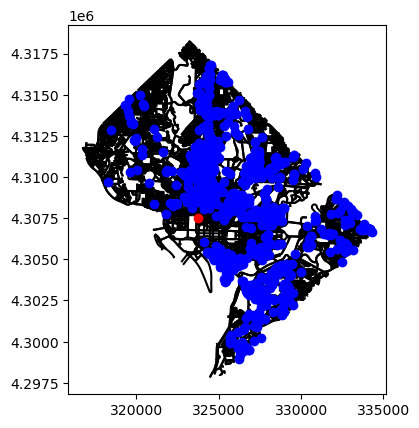

In [97]:
# Map data to make sure everything lines up
ax = dc_network_edges.plot(color='black', zorder=1)
affordable_housing.plot(ax=ax, color='blue', zorder=2)
metro_center.plot(ax=ax, color='red', zorder=3)

## Relate points to street network

In [101]:
# Find the nearest node to metro center
metro_center_nodes, metro_center_node_dists = ox.nearest_nodes(
    dc_network_g,
    metro_center.geometry.get_coordinates().x, 
    metro_center.geometry.get_coordinates().y, 
    return_dist=True)

In [110]:
metro_center_nodes

[49745629]

In [105]:
metro_center_node_dists

[74.35849321090423]

In [102]:
# Find the nearest nodes to affordable housing units
affordable_housing_nodes, affordable_housing_node_dists = ox.nearest_nodes(
    dc_network_g,
    affordable_housing.head(100).geometry.get_coordinates().x,
    affordable_housing.head(100).geometry.get_coordinates().y,
    return_dist=True)

In [107]:
affordable_housing_nodes[:5]

[49807765, 49763450, 49790538, 1472831067, 3661066113]

In [108]:
affordable_housing_node_dists[:5]

[33.91605174188366,
 44.405100455622225,
 54.892813796057176,
 56.58847166530133,
 80.40767204459081]

## Calculate shortest path

In [114]:
# Calculate shortest path
affordable_housing_node = affordable_housing_nodes[0]
metro_center_node = metro_center_nodes[0]

route = ox.shortest_path(
    dc_network_g, 
    affordable_housing_node, 
    metro_center_node, 
    weight='length',
)

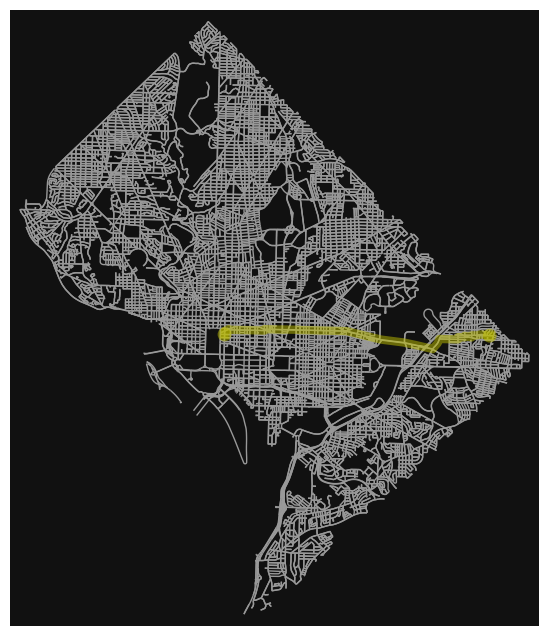

In [113]:
fig, ax = ox.plot_graph_route(dc_network_g, route, route_color="y", route_linewidth=6, node_size=0)

## Calculate travel time

In [118]:
dc_network_edges.head()

osmid lanes  \
u         v         key                                             
49184747  937305437 0                             422411000     2   
          49198976  0                             535468569     2   
          49786378  0    [1160242529, 535468796, 520475705]   NaN   
937305437 49184747  0                             422411000     2   
          49768215  0                             422411000     2   

                                                name      highway  oneway  \
u         v         key                                                     
49184747  937305437 0       Western Avenue Northwest      primary   False   
          49198976  0       Western Avenue Northwest      primary   False   
          49786378  0    Chesapeake Street Northwest  residential   False   
937305437 49184747  0       Western Avenue Northwest      primary   False   
          49768215  0       Western Avenue Northwest      primary   False   

                        reversed   length  speed_kph  travel_time  \
u         v         key                                             
49184747  937305437 0       True   10.313       45.1          0.8   
          49198976  0      False   69.211       45.1          5.5   
          49786378  0       True  121.848       37.0         11.9   
937305437 49184747  0      False   10.313       45.1          0.8   
          49768215  0       True   70.892       45.1          5.7   

                                                                  geometry  \
u         v         key                                                      
49184747  937305437 0    LINESTRING (318181.718 4313438.616, 318174.084...   
          49198976  0    LINESTRING (318181.718 4313438.616, 318194.930...   
          49786378  0    LINESTRING (318181.718 4313438.616, 318192.973...   
937305437 49184747  0    LINESTRING (318174.084 4313431.674, 318181.718...   
          49768215  0    LINESTRING (318174.084 4313431.674, 318163.367...   

                         ref maxspeed junction bridge tunnel access width  
u         v         key                                                    
49184747  937305437 0    NaN      NaN      NaN    NaN    NaN    NaN   NaN  
          49198976  0    NaN      NaN      NaN    NaN    NaN    NaN   NaN  
          49786378  0    NaN      NaN      NaN    NaN    NaN    NaN   NaN  
937305437 49184747  0    NaN      NaN      NaN    NaN    NaN    NaN   NaN  
          49768215  0    NaN      NaN      NaN    NaN    NaN    NaN   NaN

In [117]:
# impute speed on all edges missing data
dc_network_g = ox.add_edge_speeds(dc_network_g)

# calculate travel time (seconds) for all edges
dc_network_g = ox.add_edge_travel_times(dc_network_g)

# Convert to geodataframes
dc_network_nodes, dc_network_edges = ox.graph_to_gdfs(dc_network_g)

In [119]:
route = ox.shortest_path(
    dc_network_g, 
    affordable_housing_node, 
    metro_center_node, 
    weight='travel_time',
)

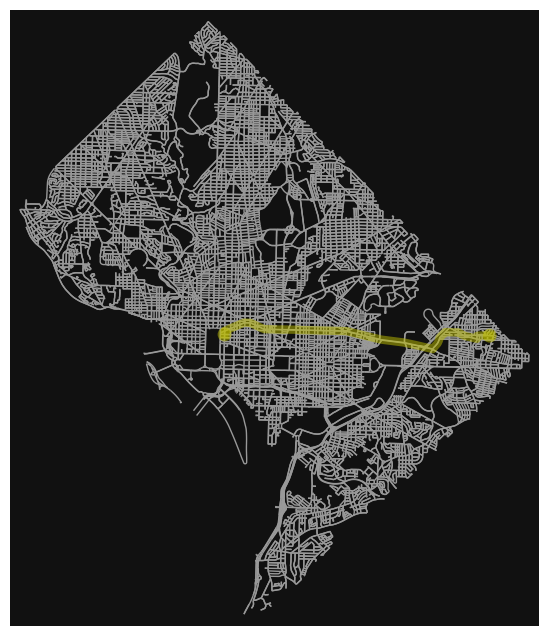

In [120]:
fig, ax = ox.plot_graph_route(dc_network_g, route, route_color="y", route_linewidth=6, node_size=0)

In [129]:
# Add up travel time and distance along the route
ox.routing.route_to_gdf(dc_network_g, route)['travel_time'].sum()

817.3000000000002

In [130]:
ox.routing.route_to_gdf(dc_network_g, route)['length'].sum()

9874.005000000001

## Loop calculations for bulk processing

In [153]:
def shortest_paths_to_metro_center(graph, o_nodes, d_node, weight='length'):    
    # Calculate shortest paths between each O-D pair
    d_nodes = [d_node] * len(o_nodes)
    routes = ox.shortest_path(graph, o_nodes, d_nodes, weight)
    # Gather data for edges along each route
    combined_route_edges = []
    for route, o_node in zip(routes, o_nodes):
        route_edges = ox.routing.route_to_gdf(dc_network_g, route)
        route_edges['o'] = o_node
        route_edges['d'] = d_node
        combined_route_edges.append(route_edges)
    combined_route_edges = pd.concat(combined_route_edges, axis=0)
    # Sum length and travel time for edges involved with each route
    route_summaries = combined_route_edges.groupby(['o','d'])[['length','travel_time']].sum()
    return route_summaries
        
routes = shortest_paths_to_metro_center(
    dc_network_g, 
    affordable_housing_nodes, 
    metro_center_node, 
    weight='length'
)

routes

,,length,travel_time
o,d,,
49190879,49745629,9462.960,817.9
49722737,49745629,1713.524,156.2
49726950,49745629,4386.088,383.6
49728949,49745629,4504.687,369.1
49731754,49745629,10220.372,840.6
...,...,...,...
8329479003,49745629,5601.555,475.3
8930818809,49745629,3696.202,314.8
9082995718,49745629,9321.196,806.8


In [151]:
affordable_housing

,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NAME,STATUS_PUBLIC,AGENCY_CALCULATED,TOTAL_AFFORDABLE_UNITS,LATITUDE,LONGITUDE,AFFORDABLE_UNITS_AT_0_30_AMI,...,AFFORDABLE_UNITS_AT_51_60_AMI,AFFORDABLE_UNITS_AT_61_80_AMI,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,MAR_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,geometry
0,95907,Ward 7,"5201 Hayes Street Northeast, Washington, Distr...",5201 Hayes Street (Deanwood Hills),Completed 2015 to Date,DMPED DCHFA DHCD OP,150,38.899430,-76.926651,40,...,100,0,0,15-10,299817,406362.59,136844.61,5201 HAYES STREET NE,2024-03-25 09:00:28+00:00,POINT (332924.776 4307381.522)
1,95908,Ward 3,"5333 Connecticut Ave NW, Washington, District ...",5333 Connecticut Ave NW,Completed 2015 to Date,DHCD,19,38.960674,-77.072513,0,...,0,9,0,None,310383,393712.05,143635.35,5333 CONNECTICUT AVENUE NW,2024-03-25 09:00:28+00:00,POINT (320426.040 4314448.307)
2,95909,Ward 4,"5741 Colorado Avenue Northwest, Washington, Di...",5741 Colorado Avenue NW Tenant Association,Completed 2015 to Date,DHCD,35,38.959500,-77.030184,2,...,7,7,0,None,257860,397383.88,143510.74,5741 COLORADO AVENUE NW,2024-03-25 09:00:28+00:00,POINT (324094.387 4314243.109)
3,95910,Ward 7,"323 62nd Street Northeast, Washington, Distric...",62nd Street Apartments (w/ PADD) - Phase II (a...,Completed 2015 to Date,DCHFA DHCD,39,38.893744,-76.911893,0,...,39,0,0,None,310426,407639.84,136228.94,323 62ND STREET NE,2024-03-25 09:00:28+00:00,POINT (334188.208 4306738.004)
4,95911,Ward 4,"6925 Georgia Avenue Northwest, Washington, Dis...",6925-6929 Georgia Avenue,Completed 2015 to Date,DMPED DCHA DHCD,27,38.974276,-77.026519,8,...,0,7,0,None,243489,397702.01,145150.91,6925 GEORGIA AVENUE NW,2024-03-25 09:00:28+00:00,POINT (324448.466 4315875.944)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,96863,Ward 8,"1286 Eaton Road Southeast, Washington, Distric...",Barry Farm Flats,Pipeline,DMPED DCHFA,98,38.859401,-76.997515,11,...,41,15,0,None,149887,400215.67,132398.51,1286 EATON ROAD SE,2024-03-25 09:00:28+00:00,POINT (326681.855 4303071.181)
877,96864,Ward 6,"1010 North Capitol Street Northwest, Washingto...",Northwest One Phase 3,Pipeline,DMPED,74,38.902850,-77.009333,74,...,0,0,194,None,313893,399190.49,137221.71,1010 NORTH CAPITOL STREET NW,2024-03-25 09:00:28+00:00,POINT (325762.616 4307915.792)
878,96865,Ward 6,"26 14th Street Southeast, Washington, District...",26 14th St SE,Completed 2015 to Date,DHCD,6,38.888966,-76.985238,0,...,0,6,0,None,289719,401280.72,135680.55,26 14TH STREET SE,2024-03-25 09:00:28+00:00,POINT (327818.591 4306329.148)
879,96866,Ward 5,"3500 12th Street Northeast, Washington, Distri...",12th Street NE Miller,Pipeline,DHCD,70,38.932680,-76.991206,18,...,0,8,0,None,152279,400762.49,140533.03,3500 12TH STREET NE,2024-03-25 09:00:28+00:00,POINT (327406.901 4311191.899)
